In [11]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import cv2
from pathlib import Path
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [12]:
import gdown
# Use the file ID from the shareable link
file_id = "1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.zip"

gdown.download(url, output, quiet=False)
!unzip -q ./data.zip -d data

Downloading...
From (original): https://drive.google.com/uc?id=1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti
From (redirected): https://drive.google.com/uc?id=1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti&confirm=t&uuid=ac2e8373-b453-42a9-810d-a1ef9f95b3f6
To: /kaggle/working/data.zip
100%|██████████| 110M/110M [00:00<00:00, 184MB/s] 


replace data/test/FAKE/0 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [13]:
# 1. Set the folder path
# --------------------------------------------------
train_REAL = "data/train/REAL"
train_FAKE = "data/train/FAKE"
test_REAL = "data/test/REAL"
test_FAKE = "data/test/FAKE"

In [14]:
# 2. DATA LOADING AND PREPARATION
# --------------------------------------------------
def load_images_from_folder(folder, label):
    """
    Loads all images from a given folder, resizes them to 32x32,
    and assigns a specified label.
    """
    images = []
    labels = []
    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

print("Loading training data...")
train_real_images, train_real_labels = load_images_from_folder(train_REAL, 1)
train_fake_images, train_fake_labels = load_images_from_folder(train_FAKE, 0)

print("Loading testing data...")
test_real_images, test_real_labels = load_images_from_folder(test_REAL, 1)
test_fake_images, test_fake_labels = load_images_from_folder(test_FAKE, 0)

X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading training data...
Loading testing data...

Training data shape: (100000, 32, 32, 3)
Testing data shape: (20000, 32, 32, 3)


In [15]:
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0
X_train_flat = X_train_normalized.reshape(100000, -1)
X_test_flat = X_test_normalized.reshape(20000, -1)

In [16]:
X_train_flat.shape

(100000, 3072)

In [17]:
TRAIN_SIZE = 10000
TEST_SIZE = 2000
X_train_reduced, _, y_train_reduced, _ = train_test_split(
    X_train_flat, y_train,
    train_size=TRAIN_SIZE,
    stratify=y_train,
    random_state=42
)

X_test_reduced, _, y_test_reduced, _ = train_test_split(
    X_test_flat, y_test,
    train_size=TEST_SIZE,
    stratify=y_test,
    random_state=42
)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)


In [19]:
%%time
# Fit PCA with maximum components (or reasonable subset)
pca_100 = PCA(n_components=100)  # Using 500 instead of 3072 for speed
pca_100.fit(X_train_scaled)

CPU times: user 9.74 s, sys: 8.37 ms, total: 9.75 s
Wall time: 3.01 s


PCA(n_components=100)

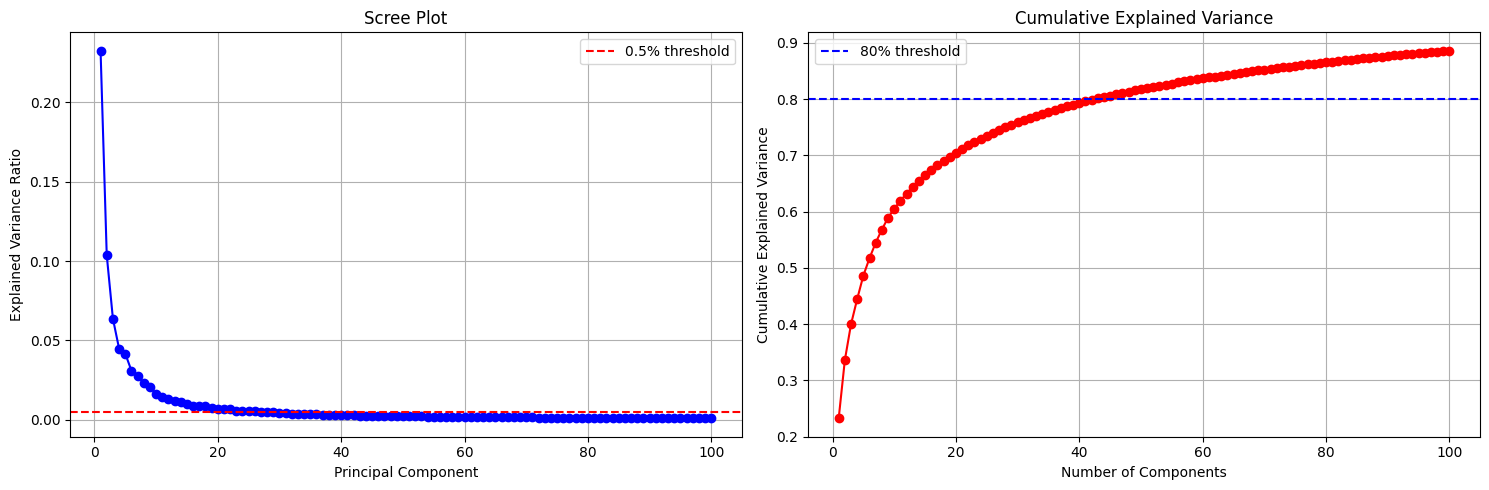

In [20]:
# Calculate cumulative explained variance
explained_variance = pca_100.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Scree plot (elbow method)
axes[0].plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
axes[0].grid(True)
axes[0].axhline(y=0.005, color='r', linestyle='--', label='0.5% threshold')
axes[0].legend()

# Plot 2: Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].axhline(y=0.80, color='b', linestyle='--', label='80% threshold')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [21]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=40, random_state=42)),
    ('svm', SVC(kernel='rbf',probability=True))
])

param_grid = {
    'svm__C': [1.0, 10.0, 100.0],
    'svm__gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3,
                           scoring='accuracy', n_jobs=-1, verbose=2)

In [22]:
X_train_reduced.shape, X_test_reduced.shape

((10000, 3072), (2000, 3072))

In [27]:
pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 60.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [28]:
%%time
print("\nTraining...")
grid_search.fit(X_train_reduced, y_train_reduced)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")



Training...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'svm__C': 1.0, 'svm__gamma': 'scale'}
Best CV score: 0.774
CPU times: user 37.4 s, sys: 1.07 s, total: 38.5 s
Wall time: 3min 45s


In [24]:
# Evaluate on train set
train_score = grid_search.score(X_train_reduced, y_train_reduced)
print(f"Train accuracy: {train_score:.3f}")

# Evaluate on test set
test_score = grid_search.score(X_test_reduced, y_test_reduced)
print(f"Test accuracy: {test_score:.3f}")

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
y_train_pred = grid_search.predict(X_train_reduced)
y_test_pred = grid_search.predict(X_test_reduced)

In [ ]:
class_names = ['Fake', 'Real']

In [ ]:
print(classification_report(y_train_reduced, y_train_pred, target_names=class_names))

In [ ]:
print(classification_report(y_test_reduced, y_test_pred, target_names=class_names))

In [ ]:
# Compute confusion matrices
cm_train = confusion_matrix(y_train_reduced, y_train_pred)
cm_test = confusion_matrix(y_test_reduced, y_test_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - Training Set', fontsize=14, fontweight='bold')
axes[0].grid(False)

# Test confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[1].grid(False)

plt.tight_layout()
plt.show()

In [ ]:
import gdown
# Use the file ID from the shareable link
file_id = "16e63C7iUB8hqG8ZoZ657JrbkwaqQzp0G"
url = f"https://drive.google.com/uc?id={file_id}"
output = "sample.zip"

gdown.download(url, output, quiet=False)
!unzip -q ./sample.zip -d largeImageTest

In [ ]:
test_large_REAL = "largeImageTest/label_0"
test_large_FAKE = "largeImageTest/label_1"

print("Loading large image test data...")
test_real_large_images, test_real_large_labels = load_images_from_folder(test_large_REAL, 1)
test_fake_large_images, test_fake_large_labels = load_images_from_folder(test_large_FAKE, 0)

X_large_test = np.concatenate((test_real_large_images, test_fake_large_images), axis=0)
y_large_test = np.concatenate((test_real_large_labels, test_fake_large_labels), axis=0)

train_indices = np.arange(X_large_test.shape[0])
np.random.shuffle(train_indices)
X_large_test = X_large_test[train_indices]
y_large_test = y_large_test[train_indices]

print(f"Testing data shape: {X_large_test.shape}")

In [ ]:
X_large_test_normalized = X_large_test.astype('float32') / 255.0
X_large_test_flat = X_large_test_normalized.reshape(2000, -1)


y_large_test_pred = grid_search.predict(X_large_test_flat)
print(classification_report(y_large_test, y_large_test_pred, target_names=class_names))


In [ ]:
import joblib
joblib.dump(grid_search, 'svm_pipeline_grid.joblib')

In [ ]:
pip install scikit-learn==1.6.1

In [ ]:
import joblib
loaded_grid = joblib.load('/kaggle/input/svm/scikitlearn/default/1/svm_pipeline_grid.joblib')

In [30]:
import shap
import numpy as np

# Model prediction function
def model_predict(x):
    return grid_search.predict_proba(x)

# Background sample for KernelExplainer
background = shap.sample(X_train_reduced, 50)

# Create the explainer on the full pipeline
explainer = shap.KernelExplainer(model_predict, background)

# Pick data to explain
X_test_sample = X_test_reduced[:10]

# Compute SHAP values in PCA space
shap_pca = explainer.shap_values(X_test_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
shap_arr = np.array(shap_pca)
arr_reordered = np.transpose(shap_arr, (1, 2, 0)) 
arr_reordered[0].shape
shap_image = arr_reordered[0][:,1].reshape(32, 32, 3)

In [37]:
def showPixelMean_RGB(img, title):
  R = img[:, :, 0]
  G = img[:, :, 1]
  B = img[:, :, 2]

  zeros = tf.zeros_like(R)

  red_only   = tf.stack([R, zeros, zeros], axis=-1)
  green_only = tf.stack([zeros, G, zeros], axis=-1)
  blue_only  = tf.stack([zeros, zeros, B], axis=-1)

  plt.figure(figsize=(10, 4))
  plt.suptitle(title, fontsize=16)

  plt.subplot(1, 3, 1)
  plt.imshow(R, cmap="seismic")
  plt.title("Red Channel (with values)")
  plt.colorbar()  # <-- shows pixel values

  plt.subplot(1, 3, 2)
  plt.imshow(G, cmap="seismic")
  plt.title("Green Channel (with values)")
  plt.colorbar()  # <-- shows pixel values

  plt.subplot(1, 3, 3)
  plt.imshow(B, cmap="seismic")
  plt.title("Blue Channel (with values)")
  plt.colorbar()  # <-- shows pixel values

  plt.show()

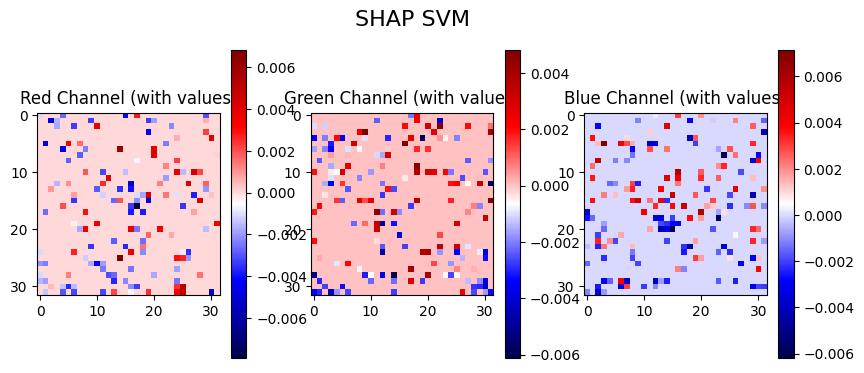

In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf

showPixelMean_RGB(shap_image,"SHAP SVM")

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

showPixelMean_RGB(shap_image,"Real Image Pixel Mean")